In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [2]:
path1 = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
path2 = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'
start = time.perf_counter()
detroit_911 = pd.read_csv(path1, thousands = ",")#, nrows = 100000)
print(time.perf_counter() - start)

131.5684031


## Clean the Data

In [116]:
# Make a copy of the dataframe so that I don't have to redownload it every time I want to refresh.
detroit_df = detroit_911.copy()

# Count all the null values in the columns
null_values = detroit_911.isnull().sum()
#print('Null values prior to dropping columns.')
#print(null_values)

# Drop columns that will not be used in algorithm
detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

#print('\nNull values after dropping columns')
#print(detroit_df.isnull().sum())


mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

### Fix Missing Priorities

In [117]:
priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key
        
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


In [118]:
# for column in detroit_df.columns:
#     print(f'{column}\nNumber of Values: {len(detroit_df[column].unique())}\n')

In [119]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)


### Convert timestamp to weekday

In [120]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

In [121]:
def get_daypart(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00')
    time = dt.datetime.strftime(time, '%H:%M:%S')
    if time < "06:00":
        time_of_day = "Early Morning"
    elif time >= "06:00" and time < "10:00":
        time_of_day = "Morning"
    elif time >= "10:00" and time < "12:00":
        time_of_day = "Late Morning"
    elif time >= "12:00" and time < "15:00":
        time_of_day = "Afternoon"
    elif time >= "15:00" and time < "18:00":
        time_of_day = "Late Afternoon"
    elif time >= "18:00" and time < "21:00":
        time_of_day = "Early Evening"
    elif time >= "21:00":
        time_of_day = "Evening"
    else:
        time_of_day = "FAILED"
    return time_of_day

detroit_df['day_part'] = detroit_df['call_timestamp'].apply(lambda x: get_daypart(x))


In [122]:
detroit_df.day_part.unique()

array(['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon',
       'Early Evening', 'Evening', 'Early Morning'], dtype=object)

In [123]:
detroit_df.head()

,callcode,calldescription,call_timestamp,precinct_sca,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,825030,DISTURBANCE,2016/09/20 09:36:12+00,910A,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,811020,AUTO X UNK INJ / IMPAIRED,2016/09/20 09:46:32+00,1201,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,374030,RECOVER AUTO,2016/09/20 09:48:24+00,123B,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,825030,DISTURBANCE,2016/09/20 09:50:29+00,0207,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,374030,RECOVER AUTO,2016/09/20 09:54:37+00,28A,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


In [124]:
detroit_df.drop(columns = ['callcode','call_timestamp','precinct_sca'], inplace = True)

In [125]:
detroit_df.drop(columns = ['calldescription'], inplace = True)
detroit_df

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning
...,...,...,...,...,...,...,...,...,...,...
2551995,No,2.2,19.3,9.1,48.0,Oakman Blvd Community,2.0,3,Monday,Late Morning
2551996,No,1.9,NaN,NaN,NaN,North Corktown,6.0,2,Monday,Late Morning
2551997,No,1.1,20.6,5.1,152.7,Oakman Blvd Community,7.0,3,Monday,Late Morning
2551998,No,0.9,0.3,7.7,213.3,Warrendale,7.0,1,Monday,Late Morning


In [126]:
detroit_df[(detroit_df[detroit_df.columns[7]] == ' ')]

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part


In [127]:
backup_detroit = detroit_df.copy()

In [128]:
backup_detroit.head()

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


In [129]:
detroit_df = backup_detroit.copy()

In [138]:
detroit_df_subset = detroit_df.head(5000)

<AxesSubplot:xlabel='time_on_scene', ylabel='Count'>

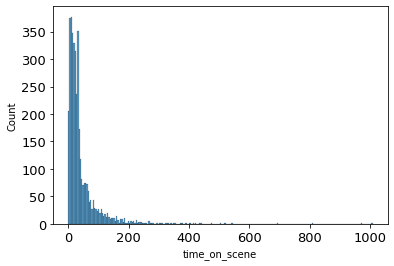

In [139]:
sns.histplot(data = detroit_df_subset, x='time_on_scene')

In [140]:
detroit_df['on_scene_2_hours'] = detroit_df['time_on_scene'].apply(lambda x: 1 if x > 32.76 else 0)

In [141]:
detroit_df['time_on_scene'].mean()

32.769917676311266

In [142]:
detroit_df.drop(columns = ['time_on_scene'], inplace = True)

In [143]:
X = detroit_df.drop(columns = ['on_scene_2_hours']).copy()

In [144]:
y_res = detroit_df['on_scene_2_hours'].copy()

In [145]:
X.select_dtypes('object')

,officerinitiated,neighborhood,priority,weekday,day_part
0,No,Wade,3,Tuesday,Morning
1,No,Tri-Point,2,Tuesday,Morning
2,No,Oak Grove,3,Tuesday,Morning
3,No,We Care Community,3,Tuesday,Morning
4,No,Barton-McFarland,3,Tuesday,Morning
...,...,...,...,...,...
2551995,No,Oakman Blvd Community,3,Monday,Late Morning
2551996,No,North Corktown,2,Monday,Late Morning
2551997,No,Oakman Blvd Community,3,Monday,Late Morning
2551998,No,Warrendale,1,Monday,Late Morning


In [146]:
y_res.unique()

array([1, 0], dtype=int64)

In [147]:
X_encoded = pd.get_dummies(X)
# detroit_dummied.shape

# It is better to use One-Hot-Encoding than get_dummies because OHE saves the exploded categories into its object, but we are using get_dummies for ease



In [148]:
X_encoded.head()

,intaketime,dispatchtime,traveltime,council_district,officerinitiated_No,officerinitiated_Yes,neighborhood_Airport Sub,neighborhood_Arden Park,neighborhood_Aviation Sub,neighborhood_Bagley,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,day_part_Afternoon,day_part_Early Evening,day_part_Early Morning,day_part_Evening,day_part_Late Afternoon,day_part_Late Morning,day_part_Morning
0,2.2,528.6,15.5,4.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2.7,5.2,6.4,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,4.9,NaN,NaN,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.4,3.4,7.6,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,3.0,1645.3,NaN,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [149]:
X_encoded.fillna(0, inplace = True)

In [150]:
print(sum(y_res)/len(y_res))

0.23170807210031347


In [ ]:
def check_dmatrix(X,y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=0, seed=42)
    clf_xgb.fit(X_train, 
                y_train, 
                verbose = True,
                early_stopping_rounds=10, 
                eval_metric='aucpr',
                eval_set=[(X_test, y_test)]
               )
    
    accuracy = clf_xgb.score(X_test, y_test)
    scores.append([size,accuracy])

X_encoded.isna().sum().sum()

scores = []
sizes = [100,1000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000] + [_ for _ in range(200000,2500000,100000)]
sizes = [2500000]
for size in sizes:
    if size < 2500000:
        continue
    X_subset = X_encoded.head(size)
    y_subset = y_res.head(size)

    ## converting to numpy array
    # X_subset = X_subset.to_numpy()
    # y_subset = y_subset.to_numpy()
    
    # print(X_subset)
    check_dmatrix(X_subset,y_subset, size)
    print(f'Current Size: {size}')
    # print('Not Running the Model currently')
    



In [168]:
score_frame = pd.DataFrame(scores, columns = ['size','accuracy'])

In [179]:
prediction_scores = pd.read_csv('prediction_scores_xgb_baseline.csv')
prediction_scores.head(1)

,num_observations,32.7 minutes,120 minutes,difference
0,100,0.75,0.95,0.2


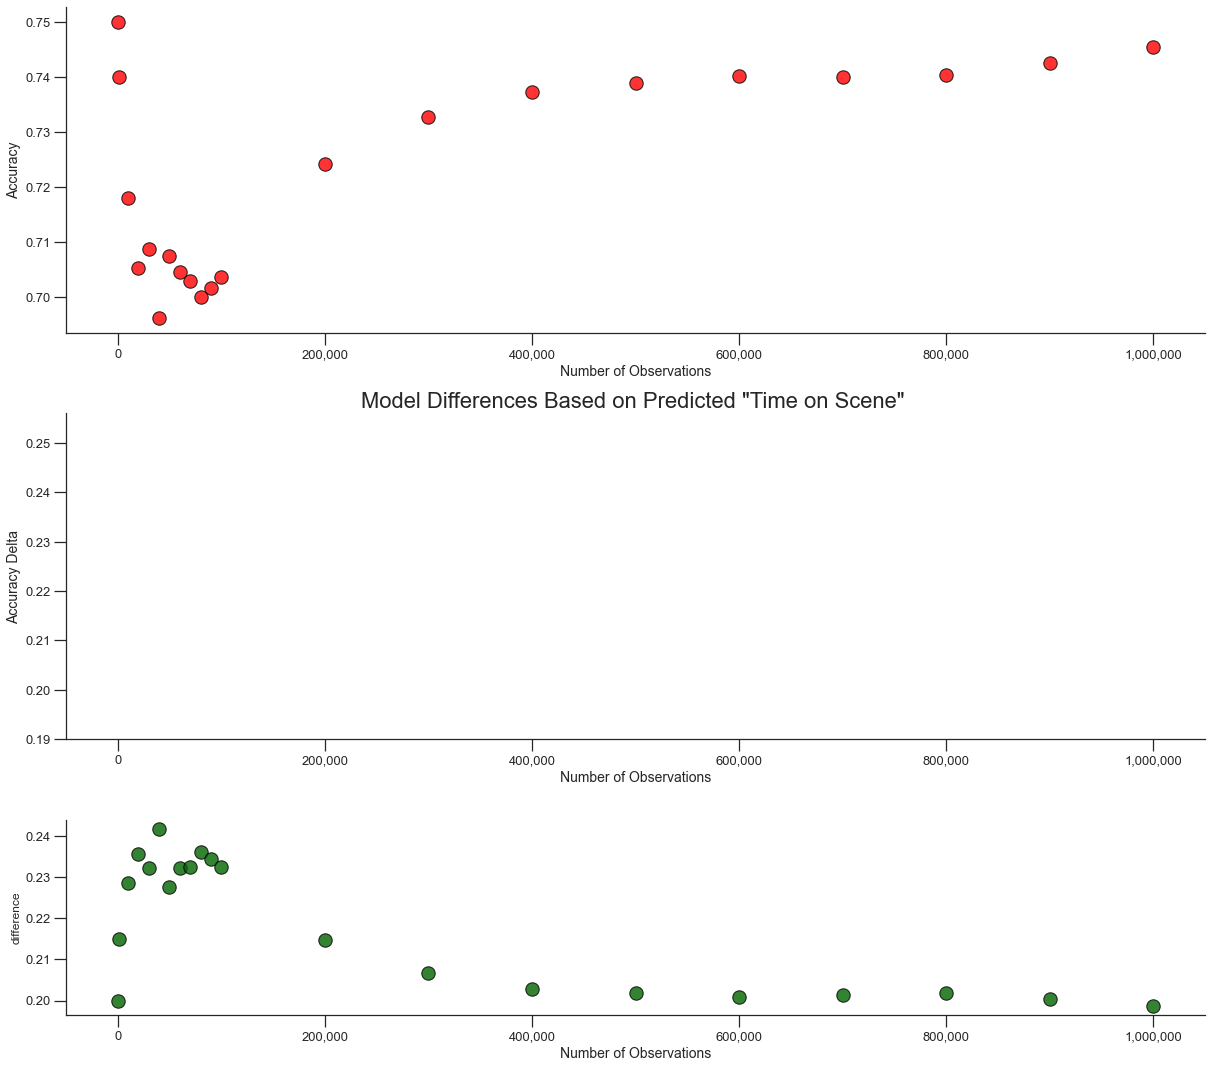

In [212]:
score_frame = prediction_scores
sns.set_style('ticks')

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(3, 1, figsize = (17,15), gridspec_kw={'height_ratios':[.5,.5,.3]}, sharex = False)
#plt.title("Accuracy vs. Number of Observations", fontsize = 22)
axs[1].set_title('Model Differences Based on Predicted "Time on Scene" ', fontsize = 22)

sns.scatterplot(data = score_frame, x = 'num_observations', y = '32.7 minutes', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[0])
sns.scatterplot(data = score_frame, x = 'num_observations', y= '120 minutes', s= 180, alpha = .8, edgecolor = 'black', color = 'blue', ax = axs[1])
sns.scatterplot(data = score_frame, x = 'num_observations', y= 'difference', s= 180, alpha = .8, edgecolor = 'black', color = 'darkgreen', ax = axs[2])

# axs[0].axhline(score_frame['accuracy'].max(), color = 'black', linestyle = 'dashed')
# plt.axhline(score_frame['accuracy'].min(), color = 'black', linestyle = 'dashed')
# plt.axhline(score_frame['accuracy'].mean(), color = 'black', linestyle = 'dashed')
axs[0].set_ylabel('Accuracy', fontsize = 14)
axs[1].set_ylabel('Accuracy Delta', fontsize = 14)
axs[1].set_ylim([0.19,.256])
# ax.set_xlim([-1000,2500000])
#ax[1].set_ylim([.95,.955])
for ax in axs:
    ax.ticklabel_format(style = 'plain')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(size = 12)
    ax.set_xlabel("Number of Observations", fontsize = 14)
    
# most_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].max())]["size"].values[0]
# least_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].min())]["size"].values[0]
# ax.annotate(f'Max Accuracy: {(score_frame["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
#             xy= [100000,.95556], 
#             fontsize = 16)
# ax.annotate(f'Min Accuracy: {(score_frame["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
#             xy= [150000,.934], 
#             fontsize = 16)
#sns.set(rc = {'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.despine()
plt.tight_layout()
#plt.savefig("XGB_classifier_vs-3")

In [38]:
other_data = pd.read_csv('xgb_classifier_attempt_1.csv')
other_data = other_data.tail(5)

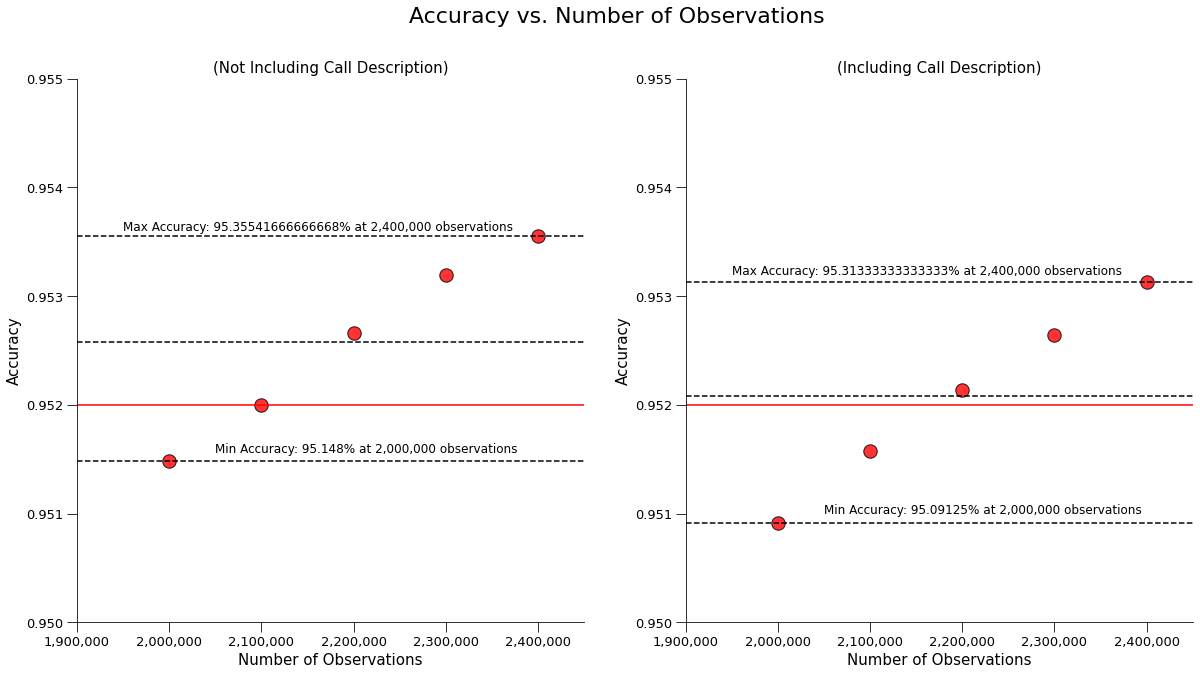

In [86]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(1,2, figsize = (20,10))
fig.suptitle("Accuracy vs. Number of Observations", fontsize = 22)
axs[0].set_title("(Not Including Call Description)", fontsize = 15)
axs[1].set_title("(Including Call Description)", fontsize = 15)

sns.scatterplot(data = other_data, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[0])
axs[0].axhline(other_data['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].mean(), color = 'black', linestyle = 'dashed')

sns.scatterplot(data = score_frame, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[1])
axs[1].axhline(score_frame['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].mean(), color = 'black', linestyle = 'dashed')

axs[0].axhline(.952, color = 'red')
axs[1].axhline(.952, color = 'red')

axs[0].set_xlabel('Number of Observations', fontsize = 15)
axs[0].set_ylabel('Accuracy', fontsize = 15)
axs[0].tick_params(size = 10)
axs[0].set_xlim([1900000,2450000])
axs[0].set_ylim([.95,.955])
axs[0].ticklabel_format(style = 'plain')
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = other_data[(other_data.accuracy == other_data["accuracy"].max())]["size"].values[0]
least_accurate = other_data[(other_data.accuracy == other_data["accuracy"].min())]["size"].values[0]
axs[0].annotate(f'Max Accuracy: {(other_data["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9536], 
            fontsize = 12)
axs[0].annotate(f'Min Accuracy: {(other_data["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.95156], 
            fontsize = 12)


axs[1].set_xlabel('Number of Observations', fontsize = 15)
axs[1].set_ylabel('Accuracy', fontsize = 15)
axs[1].tick_params(size = 10)
axs[1].set_xlim([1900000,2450000])
axs[1].set_ylim([.95,.955])
axs[1].ticklabel_format(style = 'plain')
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].max())]["size"].values[0]
least_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].min())]["size"].values[0]
axs[1].annotate(f'Max Accuracy: {(score_frame["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9532], 
            fontsize = 12)
axs[1].annotate(f'Min Accuracy: {(score_frame["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.951], 
            fontsize = 12)

sns.set

sns.despine()
#plt.savefig("XGB_classifier_vs-2")

In [ ]:
detroit_df.shape

bst = clf_xgb.get_booster()
for importance_type in ('weight','gain','gain','cover','total_gain','total_cover'):
    p

xgb.to_graphviz(clf_xgb,
                num_trees=0,
                size="10,10"
                condition_node_params=node_parmas,
                leaf_node_params=leaf_params
               )